In [1]:
import sys

import pylibxc
import numpy as np
import matplotlib.pyplot as plt

def get_density(r_s):
  return 3/(4*np.pi*(r_s ** 3))

def hartree_to_mRy(energy):
  return energy * 2 * 1000

def get_eps_x_unif(n):
  return -(3/(4*np.pi))*((n*3*np.pi**2)**(1/3))

def get_grad_n(s, n):
  return s*((n**(4/3))*2*(3*np.pi**2)**(1/3))

def get_up_dn_density(n, zeta):
  n = np.expand_dims(n.flatten(), axis=1)
  zeta = np.expand_dims(zeta.flatten(), axis=1)

  up_density = ((zeta * n) + n)/2
  dn_density = (n - (zeta * n))/2
  return np.concatenate((up_density, dn_density), axis=1)

def get_tau(alpha, grad_n, n):
  tau_w = (grad_n**2) / (8*n)
  tau_unif = (3/10)*((3*np.pi)**(2/3))*(n**(5/3))
  
  return (alpha*tau_unif) +tau_w

eps_x = eps_c = 'zk'


In [59]:
# test LDA

# build functional
lda = pylibxc.LibXCFunctional("lda_c_vwn", "unpolarized")


r_s = np.linspace(0.5, 10)
r_s = np.array([0.5, 1, 2, 3, 4, 5, 6, 10])

r_s = 1
gams = np.linspace(1, 10)


# create input
inp = {}
inp["rho"] = get_density(r_s/gams)

# results in a.u.
lda_res = lda.compute(inp)


# processing
lda_res[eps_c] = np.squeeze(lda_res[eps_c])

In [ ]:
# plots
fig, ax = plt.subplots()

ax.plot(gams, lda_res[eps_c], label=r'$\epsilon_{\mathrm{C}}^{\mathrm{VWN}}(r_s / \gamma)$')
ax.plot(gams, lda_res[eps_c][0] * gams, label=r'$ \gamma \, \epsilon_{\mathrm{C}}^{\mathrm{VWN}}(r_s)$')

ax.set_xlabel(r'$\gamma$')
ax.legend()

In [2]:
# unpolarized PBE

# build functional
pbe_x = pylibxc.LibXCFunctional("gga_x_pbe", "unpolarized")
pbe_c = pylibxc.LibXCFunctional("gga_c_pbe", "unpolarized")

r_s = np.array([0.5, 1, 2, 3, 4, 5, 6, 10, 20, 40, 60, 100])
#r_s = np.array([0.01, 2, 10, 1000])

s = np.linspace(0, 5)

m_r_s, m_s = np.meshgrid(r_s, s, indexing='ij')

m_n = get_density(m_r_s)
m_sigma = get_grad_n(m_s, m_n)
m_eps_x_unif = get_eps_x_unif(m_n)

# create input
inp = {}
# density
inp["rho"] = m_n.flatten()
# | \nabla n |^2
inp["sigma"] = m_sigma.flatten()**2 


In [19]:
# results in a.u.
pbe_x_res = pbe_x.compute(inp)
pbe_c_res = pbe_c.compute(inp)

In [20]:
# processing 

pbe_x_res[eps_x] = np.squeeze(pbe_x_res[eps_x])
pbe_c_res[eps_c] = np.squeeze(pbe_c_res[eps_c])

pbe_xc_res = pbe_c_res[eps_c] #+ pbe_x_res[eps_x]
pbe_xc_res = pbe_xc_res.reshape(m_r_s.shape)

# F_xc
pbe_xc_res /= m_eps_x_unif

(0.0, 3.0)

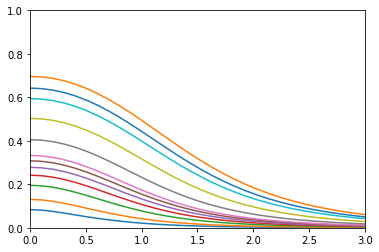

In [26]:
# plotting
# permute axes for plots
perm = [1, 0]

plt.plot(np.transpose(m_s, perm), np.transpose(pbe_xc_res, perm))

plt.ylim(0, 1)

plt.xlim(0, 3)

In [19]:
# polarized PBE

# build functional
pbe_x = pylibxc.LibXCFunctional("gga_x_pbe", "polarized")
pbe_c = pylibxc.LibXCFunctional("gga_c_pbe", "polarized")

r_s = np.array([0.5, 1, 2, 3, 4, 5, 6, 10, 20, 40, 60, 100])
#r_s = np.array([0.01, 2, 10, 1000])

s = np.linspace(0, 5)

zeta = np.array([-1])

m_r_s, m_s, m_zeta = np.meshgrid(r_s, s, zeta, indexing='ij')

m_n = get_density(m_r_s)
m_sigma = get_grad_n(m_s, m_n)
m_eps_x_unif = get_eps_x_unif(m_n)
m_n_spin = get_up_dn_density(m_n, m_zeta)

# create input
inp = {}

# density
inp["rho"] = m_n_spin

# (| \nabla n |^2, 0, 0) to follow libxc convention
sigma = np.expand_dims(m_sigma.flatten()**2, axis=1)
sigma = np.concatenate((sigma, np.zeros_like(sigma), np.zeros_like(sigma)), axis=1)
inp["sigma"] = sigma


In [20]:
# results in a.u.
pbe_x_res = pbe_x.compute(inp)
pbe_c_res = pbe_c.compute(inp)

In [21]:
# processing 

pbe_x_res[eps_x] = np.squeeze(pbe_x_res[eps_x])
pbe_c_res[eps_c] = np.squeeze(pbe_c_res[eps_c])

pbe_xc_res = pbe_c_res[eps_c] #+ pbe_x_res[eps_x]
pbe_xc_res = pbe_xc_res.reshape(m_r_s.shape)

# F_xc
pbe_xc_res /= m_eps_x_unif

(0.0, 3.0)

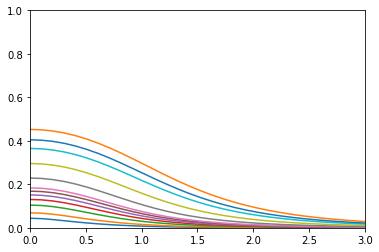

In [22]:
# plotting
# permute axes for plots
perm = [1, 0]

m_s = np.squeeze(m_s)
pbe_xc_res = np.squeeze(pbe_xc_res)

plt.plot(np.transpose(m_s, perm), np.transpose(pbe_xc_res, perm))

plt.ylim(0, 1)

plt.xlim(0, 3)

In [240]:
# unpol. SCAN
scan_x = pylibxc.LibXCFunctional("mgga_x_scan", "unpolarized")
scan_c = pylibxc.LibXCFunctional("mgga_c_scan", "unpolarized")

alpha = np.array([0, 1, 1000])
alpha = np.array([5])

#r_s = np.array([0.5, 1, 2, 3, 4, 5, 6, 10, 20, 40, 60, 100])
r_s = np.array([0.01, 0.05, 2, 10, 1000])
#r_s = np.array([1000])

s = np.linspace(0, 5)

zeta = np.array([1])

m_r_s, m_s, m_alpha = np.meshgrid(r_s, s, alpha, indexing='ij')

m_n = get_density(m_r_s)
m_grad_n = get_grad_n(m_s, m_n)
m_eps_x_unif = get_eps_x_unif(m_n)
#m_n_spin = get_up_dn_density(m_n, m_zeta)
m_tau = get_tau(m_alpha, m_grad_n, m_n)

# create input
inp = {}

# density
inp["rho"] = m_n.flatten()

inp["sigma"] = m_grad_n.flatten()**2

inp["tau"] = m_tau.flatten()

In [241]:
# results in a.u.
scan_x_res = scan_x.compute(inp)
scan_c_res = scan_c.compute(inp)

In [242]:
# processing 

scan_x_res[eps_x] = np.squeeze(scan_x_res[eps_x])
scan_c_res[eps_c] = np.squeeze(scan_c_res[eps_c])

scan_xc_res = scan_c_res[eps_c] + scan_x_res[eps_x]
scan_xc_res = scan_xc_res.reshape(m_r_s.shape)

# F_xc
scan_xc_res /= m_eps_x_unif

(0.0, 5.0)

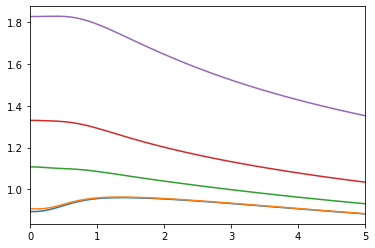

In [243]:
# plotting
# permute axes for plots
perm = [1, 0]

m_s = np.squeeze(m_s)
scan_xc_res = np.squeeze(scan_xc_res)

plt.plot(np.transpose(m_s, perm), np.transpose(scan_xc_res, perm))

#plt.ylim(1, 1.2)
plt.xlim(0, 5)


In [27]:
# pol. SCAN
scan_x = pylibxc.LibXCFunctional("mgga_x_scan", "polarized")
scan_c = pylibxc.LibXCFunctional("mgga_c_scan", "polarized")

alpha = np.array([0.01, 1, 1000])

#r_s = np.array([0.5, 1, 2, 3, 4, 5, 6, 10, 20, 40, 60, 100])
#r_s = np.array([0.01, 0.05, 2, 10, 1000])
r_s = np.array([100])

s = np.linspace(0, 5)

zeta = np.array([-1])

m_r_s, m_zeta, m_s, m_alpha = np.meshgrid(r_s, zeta, s, alpha, indexing='ij')

m_n = get_density(m_r_s)
m_grad_n = get_grad_n(m_s, m_n)
m_eps_x_unif = get_eps_x_unif(m_n)
m_n_spin = get_up_dn_density(m_n, m_zeta)
m_tau = get_tau(m_alpha, m_grad_n, m_n)

# create input
inp = {}

# density
inp["rho"] = m_n_spin

# (| \nabla n |^2, 0, 0) to follow libxc convention
sigma = np.expand_dims(m_grad_n.flatten()**2, axis=1)
sigma = np.concatenate((sigma, np.zeros_like(sigma), np.zeros_like(sigma)), axis=1)
#sigma = np.concatenate((sigma/4, sigma/4, sigma/4), axis=1)
inp["sigma"] = sigma




tau = np.expand_dims(m_tau.flatten(), axis=1)
tau = np.concatenate((tau, np.zeros_like(tau)), axis=1)
#tau = np.concatenate((tau/2, tau/2), axis=1)
inp["tau"] = tau

In [28]:
# results in a.u.
#scan_x_res = scan_x.compute(inp)
scan_c_res = scan_c.compute(inp, do_vxc=False)

In [29]:
# processing 

#scan_x_res[eps_x] = np.squeeze(scan_x_res[eps_x])
scan_c_res[eps_c] = np.squeeze(scan_c_res[eps_c])

scan_xc_res = scan_c_res[eps_c] #+ scan_x_res[eps_x]
scan_xc_res = scan_xc_res.reshape(m_r_s.shape)

# F_xc
scan_xc_res /= m_eps_x_unif

(0.0, 5.0)

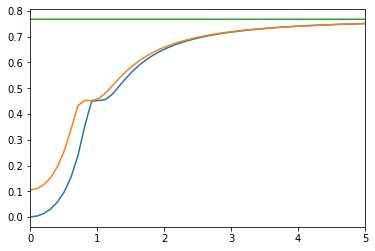

In [30]:
# plotting
# permute axes for plots
perm = [0, 1]

m_s = np.squeeze(m_s)
scan_xc_res = np.squeeze(scan_xc_res)

plt.plot(np.transpose(m_s, perm), np.transpose(scan_xc_res, perm))

#plt.ylim(1, 1.2)
plt.xlim(0, 5)
